# PNEUMONIA DETECTION USING CNN

# ~Importing Necessary Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix


# ~Dataset Preparation

In [2]:
train_dir = 'D:/chest_xray/train'
val_dir = 'D:/chest_xray/val'
test_dir = 'D:/chest_xray/test'


# ~Visualizing Sample Images

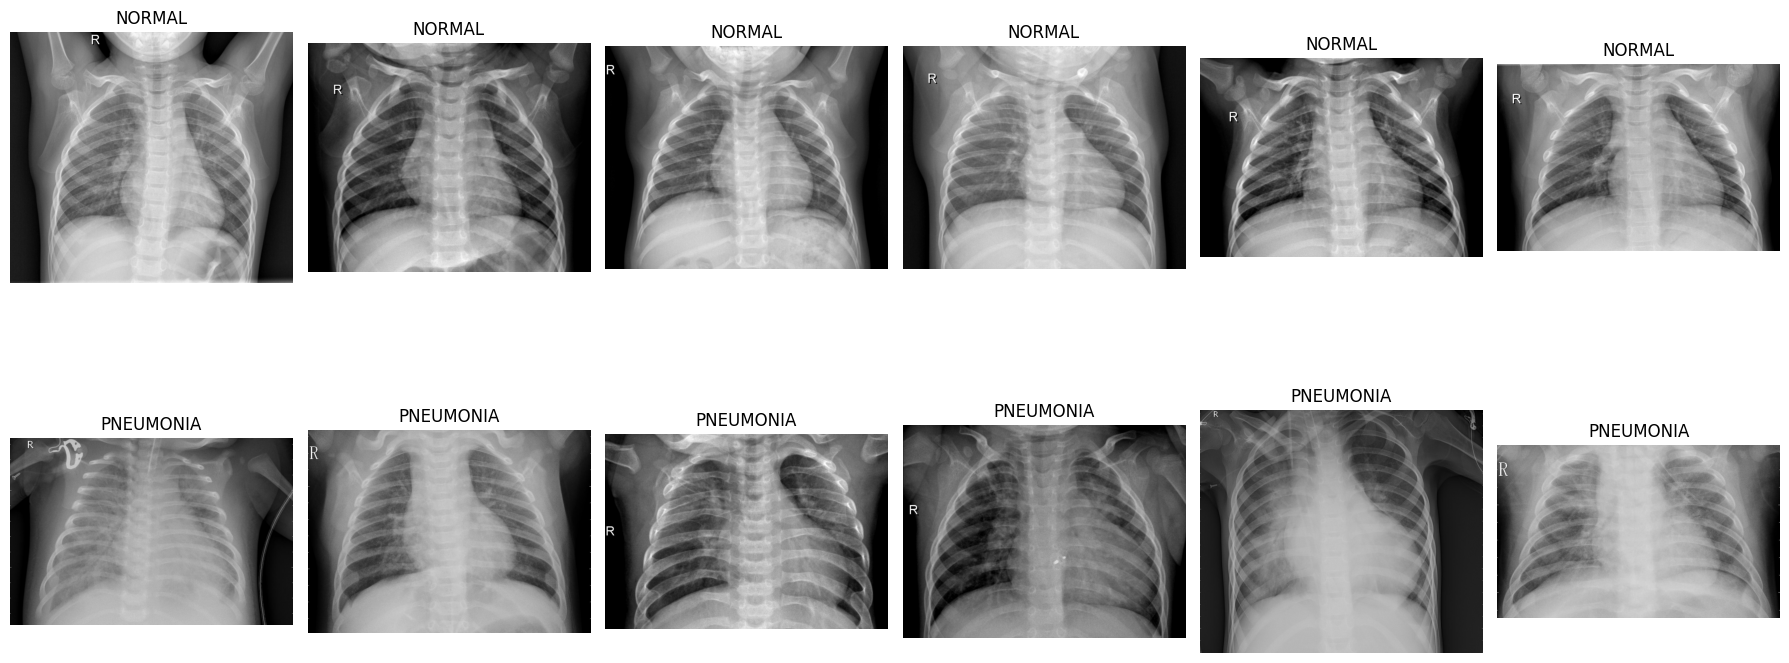

In [3]:
import os
import matplotlib.pyplot as plt

normal_dir = os.path.join(train_dir,'NORMAL')
pneumonia_dir = os.path.join(train_dir,'PNEUMONIA')

normal_images = os.listdir(normal_dir)
pneumonia_images = os.listdir(pneumonia_dir)

# Plotting NORMAL images
plt.figure(figsize=(18, 9))
for i in range(6):
    img_path = os.path.join(normal_dir, normal_images[i])
    img = plt.imread(img_path)
    plt.subplot(2, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title("NORMAL")
    plt.axis('off')

# Plotting PNEUMONIA images
for i in range(6):
    img_path = os.path.join(pneumonia_dir, pneumonia_images[i])
    img = plt.imread(img_path)
    plt.subplot(2, 6, i+7)
    plt.imshow(img, cmap='gray')
    plt.title("PNEUMONIA")
    plt.axis('off')

plt.tight_layout()
plt.show()

# ~Data Preprocessing and Augmentation

In [4]:
img_size = (150, 150)
batch_size = 16

# Training generator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

# Validation & test generators without augmentation
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Loading training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'  # use 'rgb' if your images are in color
)

# Loading validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

# Loading test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False  # important for confusion matrix
)

Found 3887 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Found 101 images belonging to 2 classes.


# ~Building and Compiling the CNN Model

In [5]:
from tensorflow.keras.optimizers import SGD

model = Sequential()

# 1. First Convolutional Layer + Pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))  # grayscale image
model.add(MaxPool2D(pool_size=(2, 2)))

# 2. Second Convolutional Layer + Pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # binary classification (0 or 1)

model.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

# Training the model

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  
    epochs=10, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,  
)

Epoch 1/10
242/242 [==============================] - 62s 253ms/step - loss: 0.6040 - accuracy: 0.7001 - val_loss: 0.6193 - val_accuracy: 0.6518
Epoch 2/10
242/242 [==============================] - 59s 242ms/step - loss: 0.5173 - accuracy: 0.7466 - val_loss: 0.4129 - val_accuracy: 0.8393
Epoch 3/10
242/242 [==============================] - 60s 248ms/step - loss: 0.3987 - accuracy: 0.8308 - val_loss: 0.3510 - val_accuracy: 0.8720
Epoch 4/10
242/242 [==============================] - 58s 238ms/step - loss: 0.3186 - accuracy: 0.8703 - val_loss: 0.3133 - val_accuracy: 0.8542
Epoch 5/10
242/242 [==============================] - 61s 254ms/step - loss: 0.2941 - accuracy: 0.8827 - val_loss: 0.2615 - val_accuracy: 0.8899
Epoch 6/10
242/242 [==============================] - 61s 254ms/step - loss: 0.2823 - accuracy: 0.8822 - val_loss: 0.2522 - val_accuracy: 0.8988
Epoch 7/10
242/242 [==============================] - 58s 241ms/step - loss: 0.2722 - accuracy: 0.8876 - val_loss: 0.2440 - val_ac

# ~Evaluating Model Performance

In [7]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss: " , test_loss)
print("Test Accuracy: " , test_accuracy)


6/6 [==============================] - 1s 87ms/step - loss: 0.1244 - accuracy: 0.9583
Test Loss:  0.12440264225006104
Test Accuracy:  0.9583333134651184


~Visualizing Training Progress

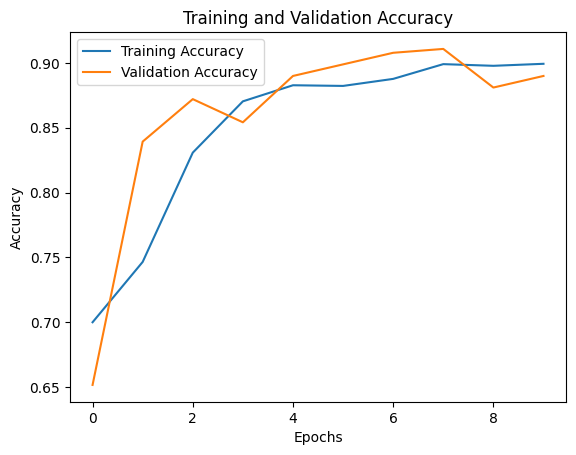

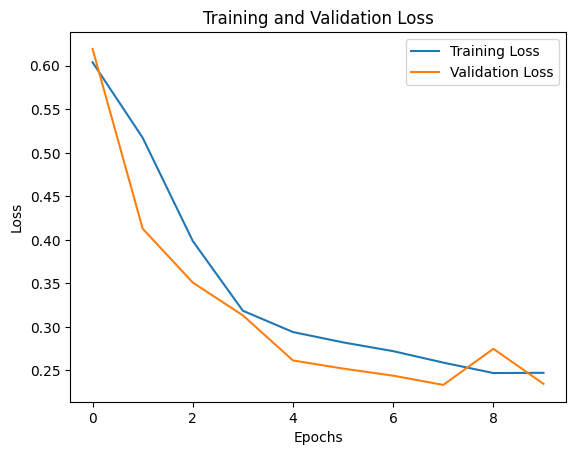

In [8]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
# Getting True labels from the test data
test_generator.reset()  
true_classes = []
for i in range(test_generator.samples // batch_size):
    images, labels = next(test_generator)
    true_classes.extend(labels) 

# Making predictions on the test data
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)
predicted_classes = (predictions > 0.5).astype("int32").flatten() 


6/6 [==============================] - 1s 69ms/step


# ~Confusion Matrix and Classification Report

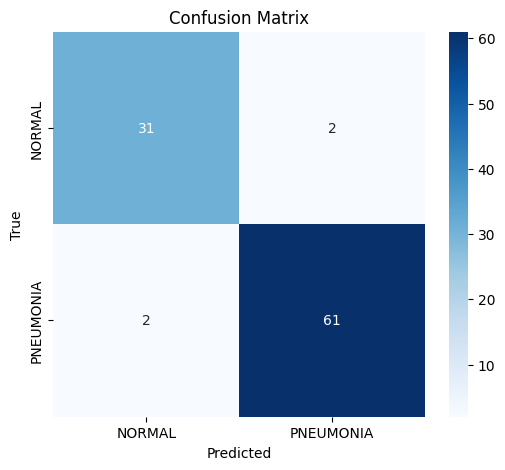

              precision    recall  f1-score   support

      NORMAL       0.94      0.94      0.94        33
   PNEUMONIA       0.97      0.97      0.97        63

    accuracy                           0.96        96
   macro avg       0.95      0.95      0.95        96
weighted avg       0.96      0.96      0.96        96



In [10]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 4. Get the classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# ~Predictions on Sample Test Images

Found 101 images belonging to 2 classes.
1/1 [==============================] - 0s 45ms/step


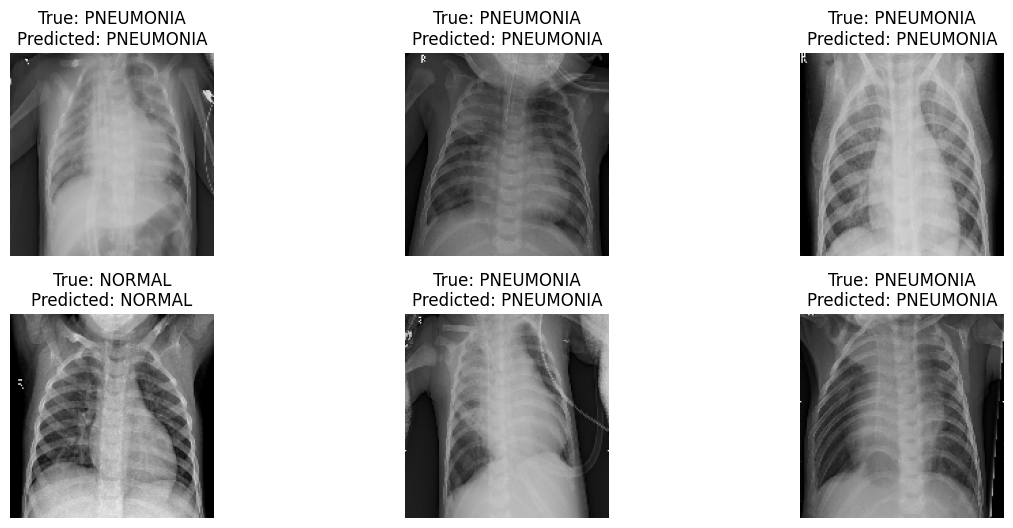

In [14]:
# Get a batch with mixed class labels
images, labels = next(viz_generator)

# Make predictions
predictions = model.predict(images)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Class labels
class_labels = list(viz_generator.class_indices.keys())

# Plot a few random images with predictions
plt.figure(figsize=(12, 8))
for i in range(min(6, len(images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(150, 150), cmap='gray')
    true_label = class_labels[int(labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title("True: " + true_label + "\nPredicted: " + predicted_label)
    plt.axis('off')
plt.tight_layout()
plt.show()


# ~CONCLUSION

The CNN model was trained for 10 epochs with a batch size of 16 on grayscale chest X-ray images of size 150×150.
During training, it achieved a final training accuracy of 90.26% and a validation accuracy of 88.10%.
When evaluated on the unseen test set, the model achieved an impressive accuracy of 95.83%